In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
!pip install adjustText


In [6]:
import pandas as pd
import gensim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import KeyedVectors
import gensim.downloader as api
from adjustText import adjust_text

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd drive/MyDrive

 drive/  'generator=mega~dataset=p1.00.jsonl'   sample_data/


In [8]:
%cd drive/MyDrive/Grover_dataset/

# %cd /content/drive/My Drive/Grover_dataset/

/content/drive/MyDrive/Grover_dataset


In [9]:
jsonl_file_path = 'generator=mega~dataset=p1.00.jsonl'

df = pd.read_json(jsonl_file_path, lines=True)

In [10]:
df.shape

(25000, 12)

In [11]:
df.sample(3)

,article,domain,title,date,authors,ind30k,url,label,orig_split,split,random_score,top_p
13404,Captain Pike gets served a horrifying slice of...,slashfilm.com,‘Star Trek: Discovery’ Shows Captain Pike His ...,2019-04-05,Monique Jones,25618,https://www.slashfilm.com/star-trek-discovery-...,human,train_burner,test,-1.810471,NaN
9161,"IQALUIT, Nunavut — Three Inuit are making a ca...",ottawacitizen.com,Lawsuit against Nunavut RCMP claims force losi...,2019-04-14,Updated,1063,https://ottawacitizen.com/news/canada/lawsuit-...,machine,gen,train,NaN,1.0
4251,Attendees at the event\nOn Thursday 28th March...,vanguardngr.com,Owens & Xley Consults Tasks Entrepreneurs to B...,2019-04-05,More Author,29584,http://allure.vanguardngr.com/2019/04/owens-xl...,human,train_burner,train,-0.188372,NaN


In [12]:
df['label'].value_counts(normalize=True)

human      0.6
machine    0.4
Name: label, dtype: float64

## Preprocessing/Cleaning the text data, using NLTK


In [13]:
article_titles = df['title']
# Creating a list of strings, one for each title
titles_list = [title for title in article_titles]

# Collapsing the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenizing the string into words
tokens = word_tokenize(big_title_string)

# Removing non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]

# Filtering out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]


['us',
 'senators',
 'threaten',
 'metro',
 'funding',
 'chinese',
 'manufacturer',
 'supply',
 'fundamentals',
 'point']

In [14]:
len(words)

189053

## Pre trained Embeddings- Word2Vec

In [15]:

# Loading pre-trained Word2Vec embeddings from gensim-data
word2vec_model_name = "word2vec-google-news-300"
model = api.load(word2vec_model_name)
model.vector_size

[==================================================] 100.0% 1662.8/1662.8MB downloaded


300

In [16]:
economy_vec = model['economy']
economy_vec[:20] # First 20 components


array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [17]:
#model.index_to_key[1]

In [18]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.key_to_index]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.key_to_index]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df_vec = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_vec.head(3)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
us,0.029907,0.056396,0.003738,0.228516,-0.079102,0.008606,0.007874,-0.137695,-0.347656,0.096191,...,-0.042969,0.287109,-0.243164,-0.094727,-0.156250,0.104492,0.074707,-0.024170,0.010864,-0.147461
senators,0.201172,0.063965,-0.091309,0.330078,-0.231445,-0.275391,-0.250000,0.308594,0.131836,0.153320,...,-0.166016,-0.031494,0.103027,-0.237305,0.250000,0.031738,-0.166992,-0.045410,0.306641,0.190430
threaten,0.017700,0.178711,0.135742,-0.089355,-0.095215,0.133789,0.023071,0.125977,-0.077148,0.222656,...,0.184570,0.138672,-0.062988,0.255859,-0.119141,-0.212891,-0.207031,-0.431641,0.091309,0.076172


In [19]:
df_vec[0]

us               0.029907
senators         0.201172
threaten         0.017700
metro            0.069336
funding         -0.008484
                   ...   
inconvenience   -0.025146
stabilizer       0.205078
imposed         -0.012878
alterations     -0.130859
weeknights      -0.019287
Name: 0, Length: 18635, dtype: float32

## Dimensionality Reduction with t-SNE

In [20]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df_vec[:400])


In [21]:
#tsne_df

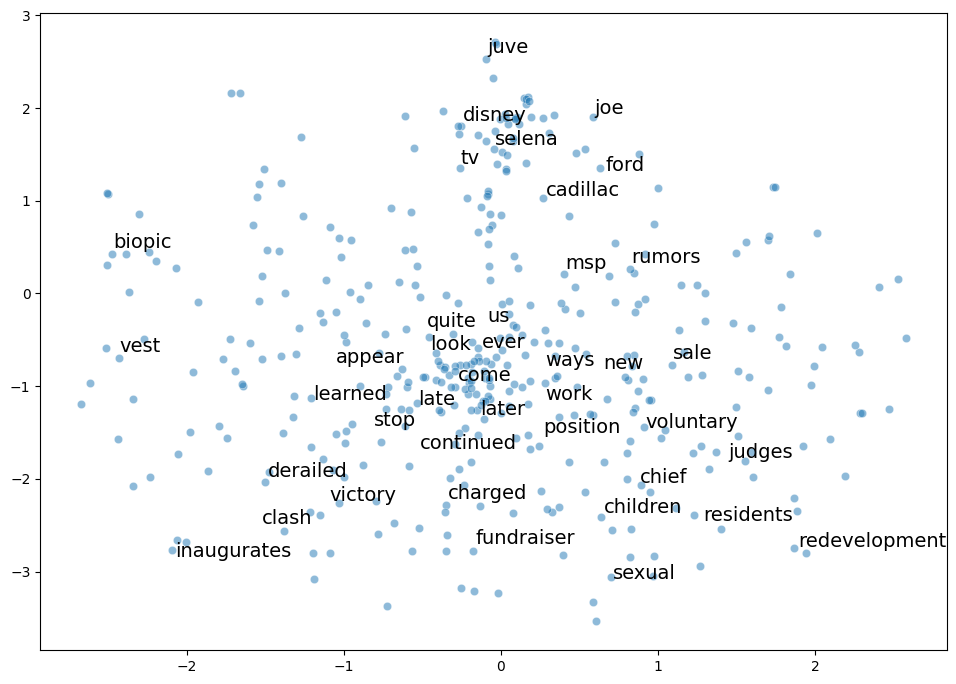

In [22]:
# Initialize t-SNE
tsne = TSNE(n_components=2, init='random', random_state=10, perplexity=100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df_vec[:400])

fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1], alpha=0.5)

texts = []
# Select words to plot
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df_vec.index[word], fontsize=14))

# Plot text using adjust_text to prevent overlap
adjust_text(texts, force_text=(0.4, 0.4), expand_points=(2, 1), expand_text=(1, 2))

plt.show()


## Averaging Word Embeddings


In [23]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.key_to_index]
    return np.mean(model[doc], axis=0)


# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc


# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.key_to_index for word in doc)


# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)


In [24]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
  x.append(document_vector(model, doc))

X = np.array(x) # list to array


0 docs removed
0 docs removed


In [25]:
corpus[0]

['us', 'senators', 'threaten', 'metro', 'funding', 'chinese', 'manufacturer']

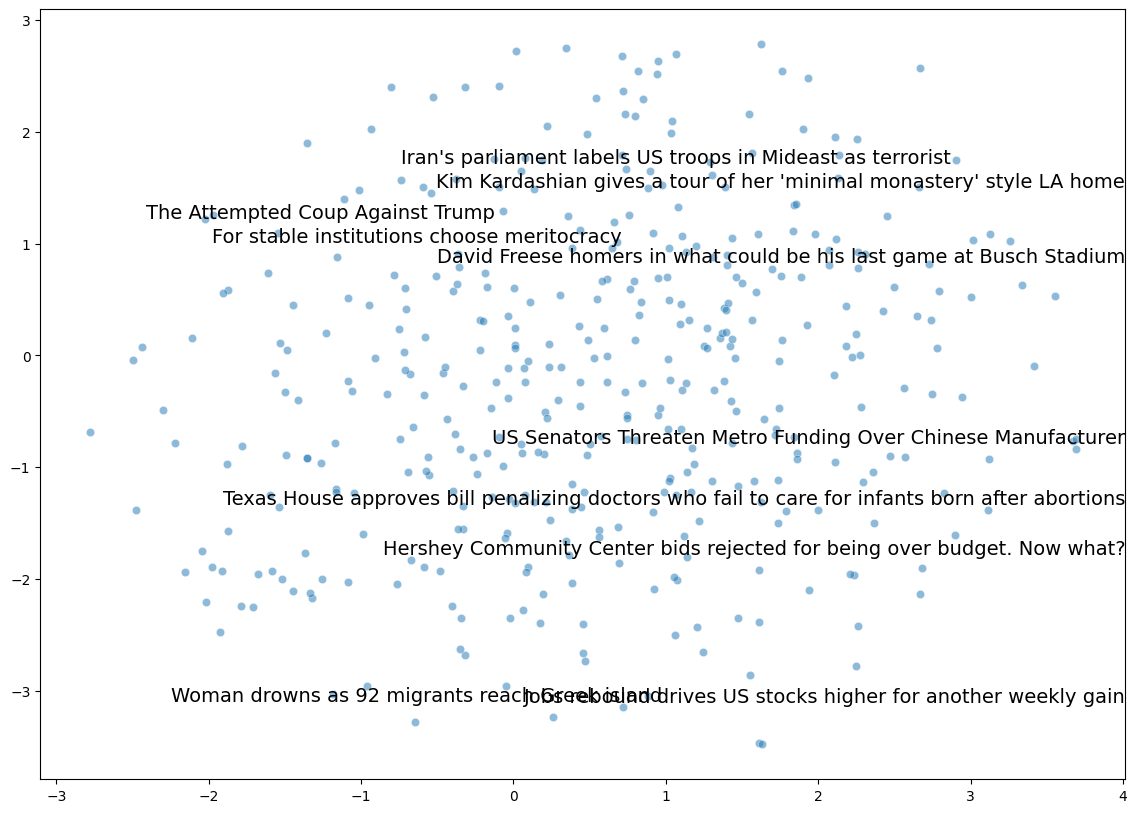

In [26]:

# Initialize t-SNE
tsne = TSNE(n_components=2, init='random', random_state=10, perplexity=100)

#400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1], alpha=0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40))  # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize=14))

# Plot text using adjust_text
adjust_text(texts, force_points=0.4, force_text=(0.4, 0.4), expand_points=(2, 1), expand_text=(1, 2))

plt.show()






## K means clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

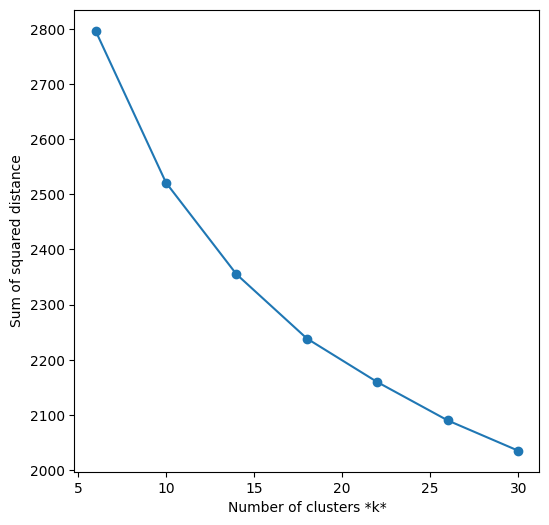

In [28]:
def implement_kmeans(k):
  headline_vectors = []
  for headline in titles_list:
      # Ignore words not in the vector dataframe
      filtered_words = [word for word in headline if word in df_vec.index]
      if filtered_words:
          # Calculate the average word vector for the headline
          headline_vector = np.mean([df_vec.loc[word] for word in filtered_words], axis=0)
          headline_vectors.append(headline_vector)

  headline_vectors = np.array(headline_vectors)

  # Step 2: Cluster the headline vectors using KMeans
  num_clusters = k
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  cluster_labels = kmeans.fit_predict(headline_vectors)

  closest_points = []
  for i in range(num_clusters):
      cluster_center = kmeans.cluster_centers_[i]
      closest_point_indices = pairwise_distances_argmin_min(cluster_center.reshape(1, -1), headline_vectors, metric='euclidean')[0]
      closest_points.append(closest_point_indices)

  # Print closest headlines for each cluster
  # for i, closest_indices in enumerate(closest_points):
  #     print(f"Cluster {i+1}:")
  #     for idx in closest_indices:
  #         print(titles_list[idx])
  #     print()

  return kmeans

sse = []
list_k = [6,10,14,18,22,26,30]

for k in list_k:
    km = implement_kmeans(k)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [29]:
sse

[2796.64501953125,
 2521.13134765625,
 2355.12744140625,
 2238.549560546875,
 2159.52734375,
 2089.96923828125,
 2035.0989990234375]

## Clustering topics

In [32]:
# topics = [
#     "Politics",
#     "Business",
#     "Technology",
#     "Health",
#     "Entertainment",
#     "Science",
#     "Environment",
#     "Sports",
#     "Education",
#     "Finance",
#     "Travel",
#     "Food",
#     "Fashion",
#     "Culture",
#     "Opinion",
#     "Weather",
#     "Crime",
#     "Art",
#     "Music",
#     "History"
# ]


# topics = [
#     "Politics",
#     "Technology",
#     "Health",
#     "Finance",
#     "Entertainment",
#     "Sports"
# ]

topics = [
    "Politics",
    "Business",
    "Technology",
    "Entertainment",
    "Sports",
    "Health",
    "Science",
    "Education",
    "Environment",
    "Travel",
    "Fashion",
    "Food",
    "Finance",
    "Weather",
    "Crime",
    "Culture",
    "Art",
    "Music",
    "Literature",
    "History"
]


In [33]:
topic_embeddings = []
for topic in topics:
    # Assuming each topic is represented by a single word
    if topic in model.key_to_index:
        embedding = model[topic]
        topic_embeddings.append(embedding)
    else:
        # Handle out-of-vocabulary topics
        print(f"Topic '{topic}' not found in vocabulary.")

# Convert to numpy array
topic_embeddings_np = np.array(topic_embeddings)


In [34]:
topic_embeddings_np.shape

(20, 300)

In [ ]:
#X.shape

In [35]:
titles_list[0]

'US Senators Threaten Metro Funding Over Chinese Manufacturer'

In [36]:
pd.DataFrame(X).head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.004368,-0.015407,0.104680,0.177455,-0.028530,-0.045855,-0.072396,0.047886,-0.033883,0.096331,...,-0.033343,0.133737,-0.068394,0.079869,0.081822,-0.031145,-0.116449,-0.030884,0.072684,-0.087716
1,-0.021077,0.088145,-0.067607,0.096110,-0.110636,-0.124268,0.037928,-0.241007,0.050659,0.071248,...,-0.072815,-0.026611,-0.025594,-0.109314,0.065389,-0.005137,0.023438,0.061479,0.070557,-0.068278
2,-0.025842,0.038177,-0.071454,-0.000482,-0.069849,-0.055313,0.008203,-0.165190,0.141162,0.038560,...,-0.032166,-0.041455,-0.009644,0.030740,0.061716,0.059814,-0.036548,-0.017151,0.083765,-0.080408


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have Word2Vec embeddings for headlines stored in a DataFrame called 'embeddings_df'
# And you have Word2Vec embeddings for topics stored in a DataFrame called 'topic_embeddings_df'


# Calculate cosine similarity between each headline and each topic
# Result will be a matrix where rows represent headlines and columns represent topics
similarities = cosine_similarity(X, topic_embeddings_np)

# Find the index of the most similar topic for each headline
most_similar_topics_indices = np.argmax(similarities, axis=1)

most_similar_topics_indices

# Map indices to topic names
most_similar_topics = [topics[index] for index in most_similar_topics_indices]

final_df = pd.DataFrame(X)
# Add the most similar topics to the original DataFrame
final_df['most_similar_topic'] = most_similar_topics


In [38]:
final_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,most_similar_topic
11233,-0.070730,-0.092489,0.000855,-0.031820,-0.043193,-0.132309,-0.030599,-0.040405,-0.060252,0.125140,...,0.050504,0.031991,0.037089,0.061422,0.080963,0.062836,-0.147420,-0.012777,-0.153198,Crime
23372,-0.001546,0.004659,0.153564,-0.127767,0.102971,0.007894,0.033529,-0.134644,0.124674,0.025340,...,0.103048,0.071574,0.025960,0.056388,-0.014811,-0.018799,-0.027354,-0.057210,-0.001877,Sports
17571,-0.038190,0.037473,0.041498,0.012140,-0.091908,-0.061213,0.055364,-0.078647,0.010121,0.035922,...,0.029441,-0.052868,0.082031,-0.049893,-0.010053,-0.033334,-0.079168,0.054210,-0.048467,Politics


In [39]:
final_df['headline'] = titles_list

In [40]:
a = final_df[['headline','most_similar_topic']].sample(200)
a.reset_index(drop = True)

,headline,most_similar_topic
0,"Racism: If you see something, say something",Crime
1,1st woman to join Notre Dame’s leprechaun masc...,Literature
2,This Is Not A Drill! Deliveroo’s Giving Away F...,Fashion
3,The Christian Science Monitor Daily for April ...,Science
4,Belgian twins freed by court amid confusion ov...,Weather
...,...,...
195,"Story Behind the Song: Toby Keith, ‘Should’ve ...",History
196,James Franco’s ‘Zeroville’ Movie Being Release...,Entertainment
197,Pioneering environmentalist Franz Weber dies a...,Environment
198,New England Patriots sign Demaryius Thomas,Weather


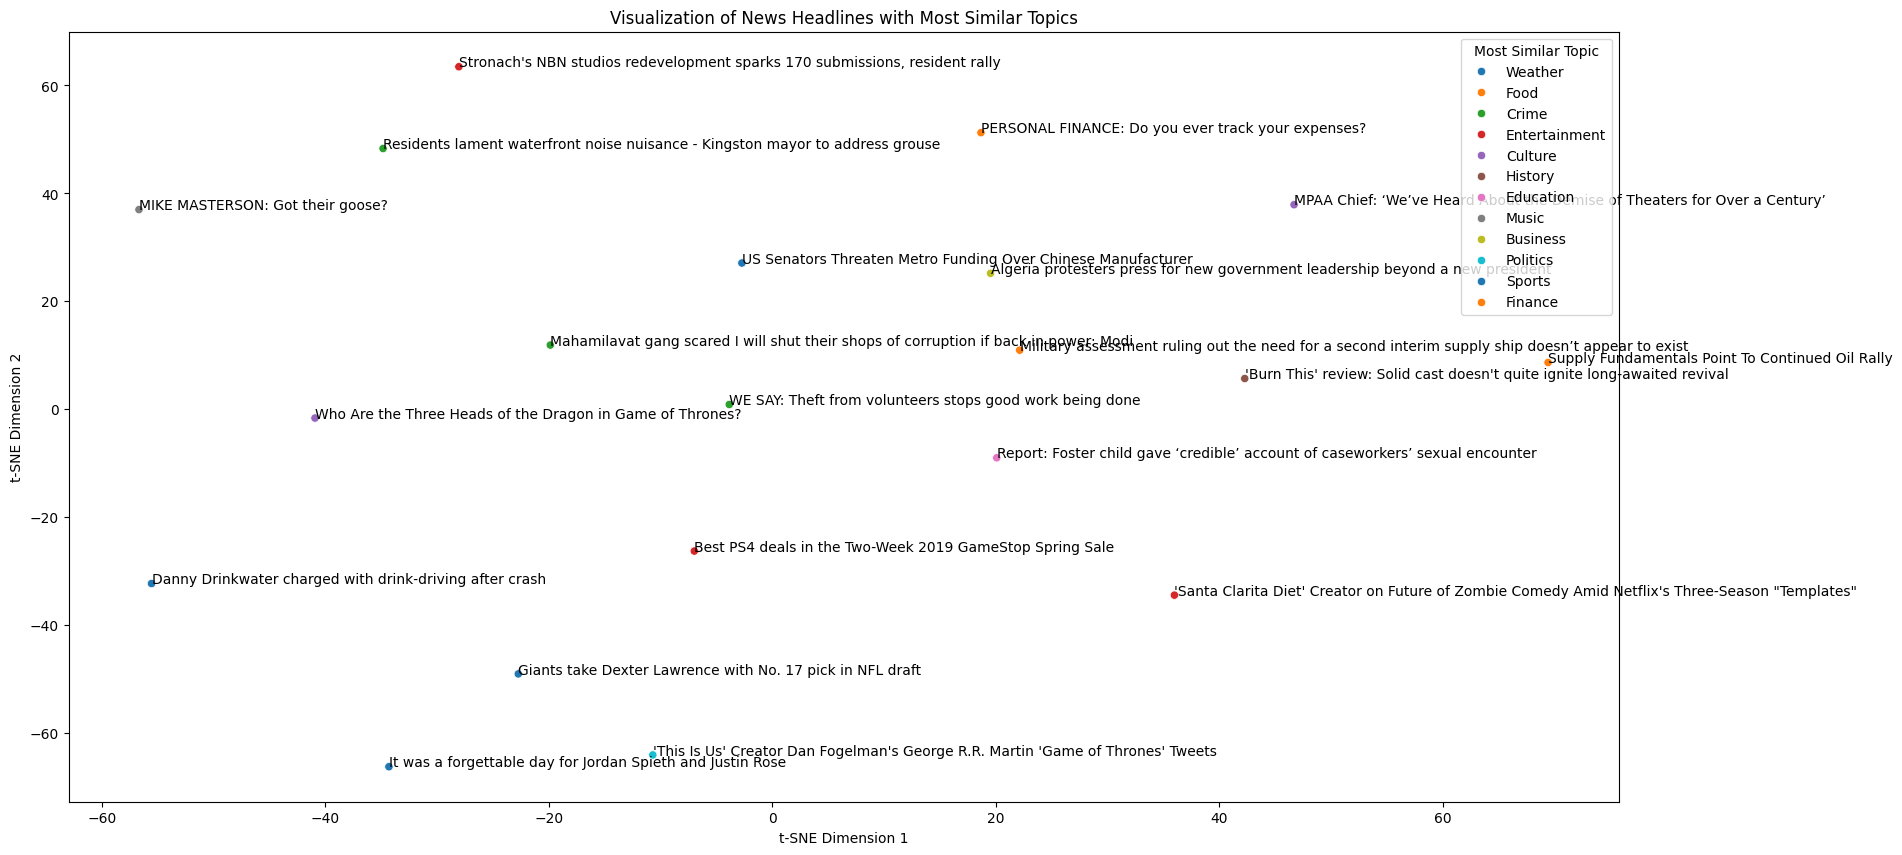

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Subset the DataFrame to include only the necessary columns (300 word embeddings and 'most_similar_topic')
subset_df = final_df.head(20)  # Limiting to 20 rows for visualization

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42,perplexity = 5)

# Fit t-SNE and transform the data
tsne_data = tsne.fit_transform(subset_df.drop(columns=['most_similar_topic', 'headline']))

# Plot the data
plt.figure(figsize=(20, 10))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=subset_df['most_similar_topic'], palette='tab10')

# Add titles to the plot
for i, txt in enumerate(subset_df['headline']):
    plt.annotate(txt, (tsne_data[i, 0], tsne_data[i, 1]))

plt.title('Visualization of News Headlines with Most Similar Topics')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Most Similar Topic')
plt.show()


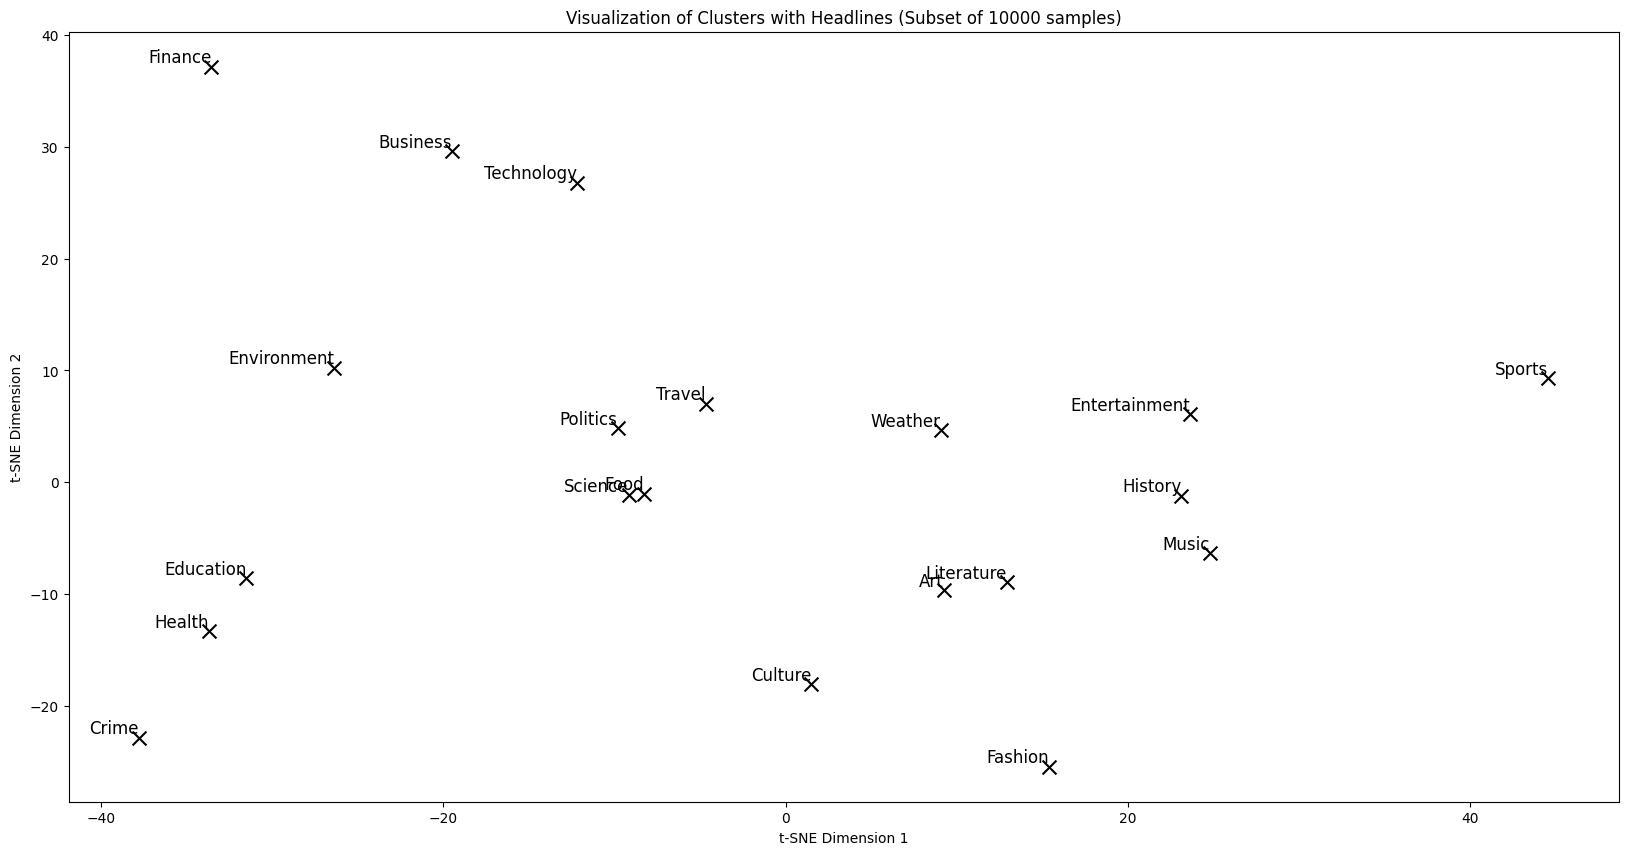

<Figure size 640x480 with 0 Axes>

In [42]:
# Reduce dimensionality of embeddings using t-SNE
subset_df = final_df.head(10000)
tsne = TSNE(n_components=2, random_state=42, perplexity= 10)
embeddings_2d = tsne.fit_transform(subset_df.drop(columns=['most_similar_topic','headline']))

# # Plot the clusters
plt.figure(figsize=(20, 10))
# for topic in subset_df['most_similar_topic'].unique():
#     indices = subset_df[subset_df['most_similar_topic'] == topic].index
#     plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=topic, alpha=0.7)

# Plot cluster centers
for topic in final_df['most_similar_topic'].unique():
    centroid = embeddings_2d[subset_df[subset_df['most_similar_topic'] == topic].index].mean(axis=0)
    plt.scatter(centroid[0], centroid[1], marker='x', color='black', s=100, label=f'{topic} centroid')
    plt.text(centroid[0], centroid[1], topic, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.title('Visualization of Clusters with Headlines (Subset of 10000 samples)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# plt.legend()
plt.show()
plt.savefig('cluster_centers.png')

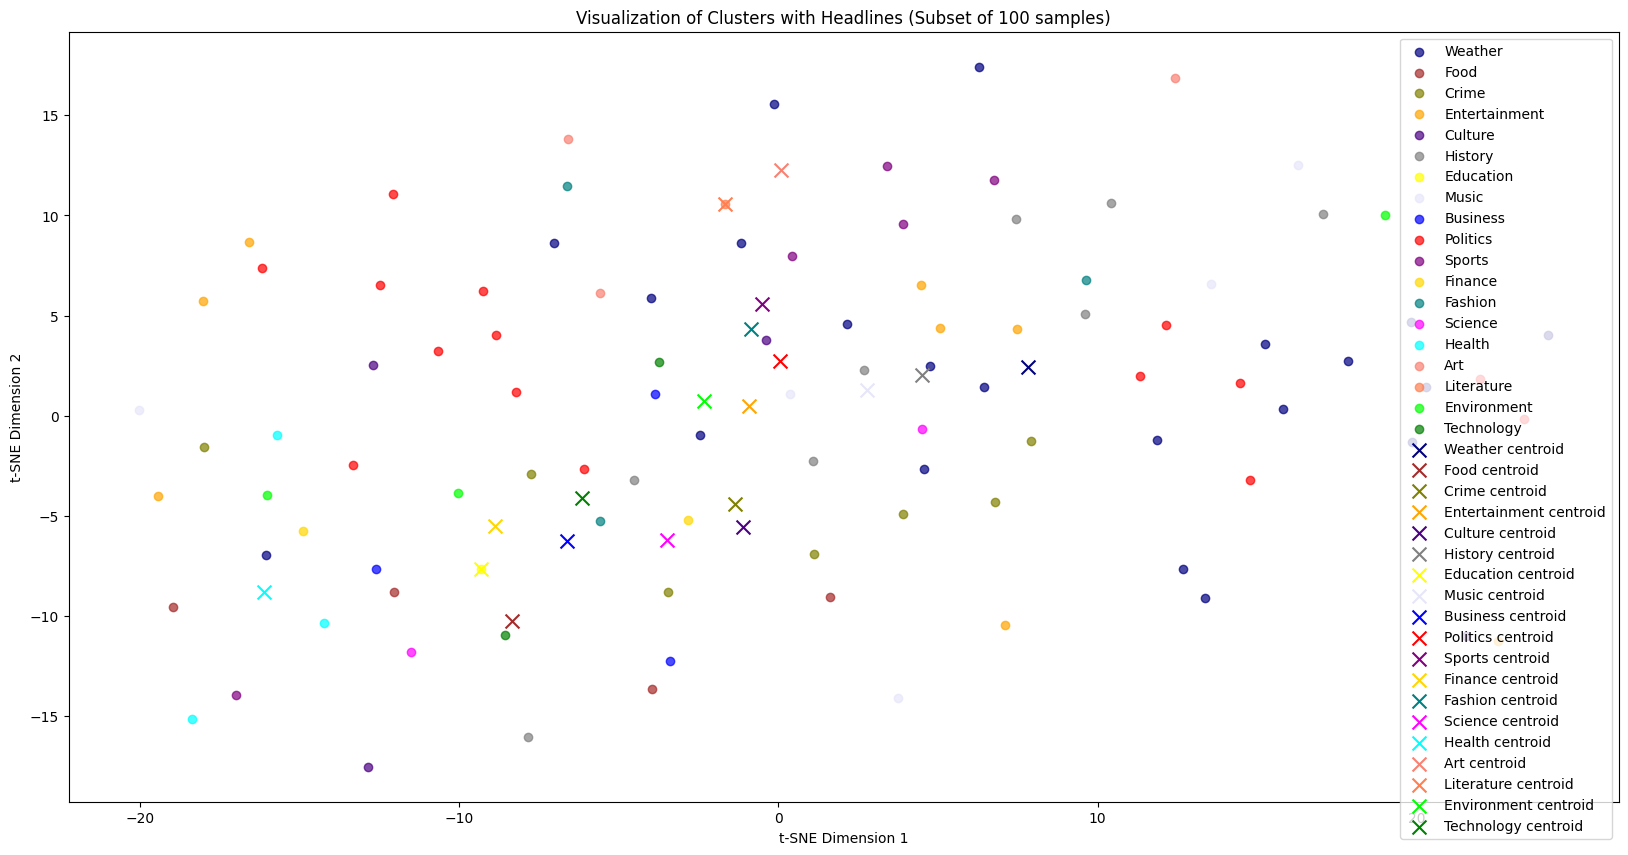

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Example embeddings_2d and subset_df
# You should replace these with your actual data
# embeddings_2d = ...
# subset_df = ...

# Define a list of colors for each unique topic
topic_colors = {
    "Politics": "red",
    "Business": "blue",
    "Technology": "green",
    "Entertainment": "orange",
    "Sports": "purple",
    "Health": "cyan",
    "Science": "magenta",
    "Education": "yellow",
    "Environment": "lime",
    "Travel": "pink",
    "Fashion": "teal",
    "Food": "brown",
    "Finance": "gold",
    "Weather": "navy",
    "Crime": "olive",
    "Culture": "indigo",
    "Art": "salmon",
    "Music": "lavender",
    "Literature": "coral",
    "History": "grey"
}

# Reduce dimensionality of embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(subset_df.drop(columns=["most_similar_topic", "headline"]))

# Plot the clusters with different colors for each topic
plt.figure(figsize=(20, 10))
for topic in subset_df["most_similar_topic"].unique():
    indices = subset_df[subset_df["most_similar_topic"] == topic].index
    plt.scatter(
        embeddings_2d[indices, 0],
        embeddings_2d[indices, 1],
        label=topic,
        color=topic_colors[topic],
        alpha=0.7
    )

# Plot cluster centers with an 'x' marker in the same color as the corresponding topic
for topic in subset_df["most_similar_topic"].unique():
    centroid = embeddings_2d[subset_df[subset_df["most_similar_topic"] == topic].index].mean(axis=0)
    plt.scatter(centroid[0], centroid[1], marker="x", color=topic_colors[topic], s=100, label=f"{topic} centroid")

plt.title("Visualization of Clusters with Headlines (Subset of 100 samples)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


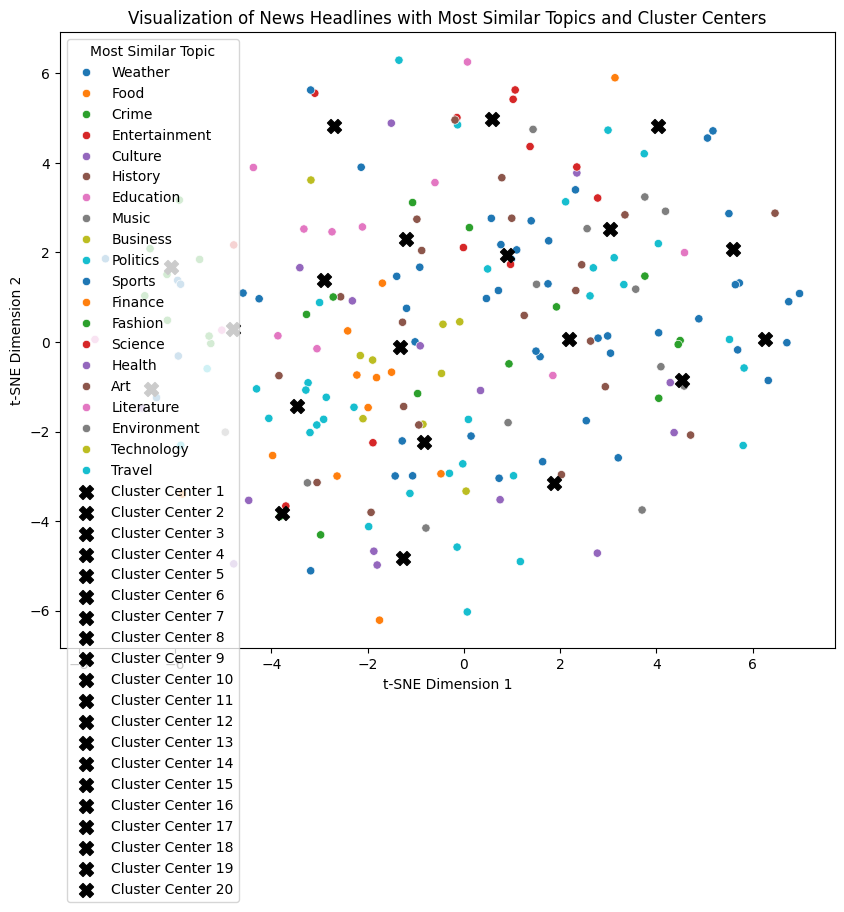

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Subset the DataFrame
subset_df = final_df.head(200)  # Limiting to 200 rows for visualization

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit t-SNE and transform the data
tsne_data = tsne.fit_transform(subset_df.drop(columns=['most_similar_topic', 'headline']))

# Cluster the data points based on 'most_similar_topic'
kmeans = KMeans(n_clusters=len(subset_df['most_similar_topic'].unique()), random_state=42)
kmeans.fit(tsne_data)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Plot the data points
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=subset_df['most_similar_topic'], palette='tab10')

# Plot cluster centers
for i, center in enumerate(cluster_centers):
    plt.scatter(center[0], center[1], marker='X', color='black', s=100, label=f'Cluster Center {i+1}')

plt.title('Visualization of News Headlines with Most Similar Topics and Cluster Centers')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Most Similar Topic')
plt.show()


## Glove

In [ ]:
#!pip install gensim==4.3.0


In [ ]:
# prompt: Extend the above to globe embeddings

# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
import gensim
import gensim.downloader as api

# Load pre-trained GloVe embeddings from gensim-data
glove_model_name = "glove-wiki-gigaword-300"
glove_model = api.load(glove_model_name)

#glove_model = api.load(glove_model_name)
glove_model.vector_size
economy_vec = glove_model['economy']
economy_vec[:20] # First 20 components


[==================================================] 100.0% 376.1/376.1MB downloaded


array([ 0.32368 , -0.14921 , -0.47491 ,  0.11804 ,  0.34319 ,  0.2301  ,
       -0.20581 ,  0.43724 ,  0.077597, -2.5859  , -0.13203 ,  0.06049 ,
       -0.36986 ,  0.41528 ,  0.47718 , -0.19045 ,  0.10687 , -0.4391  ,
        0.41823 ,  0.072872], dtype=float32)

In [ ]:
len(words)


189053

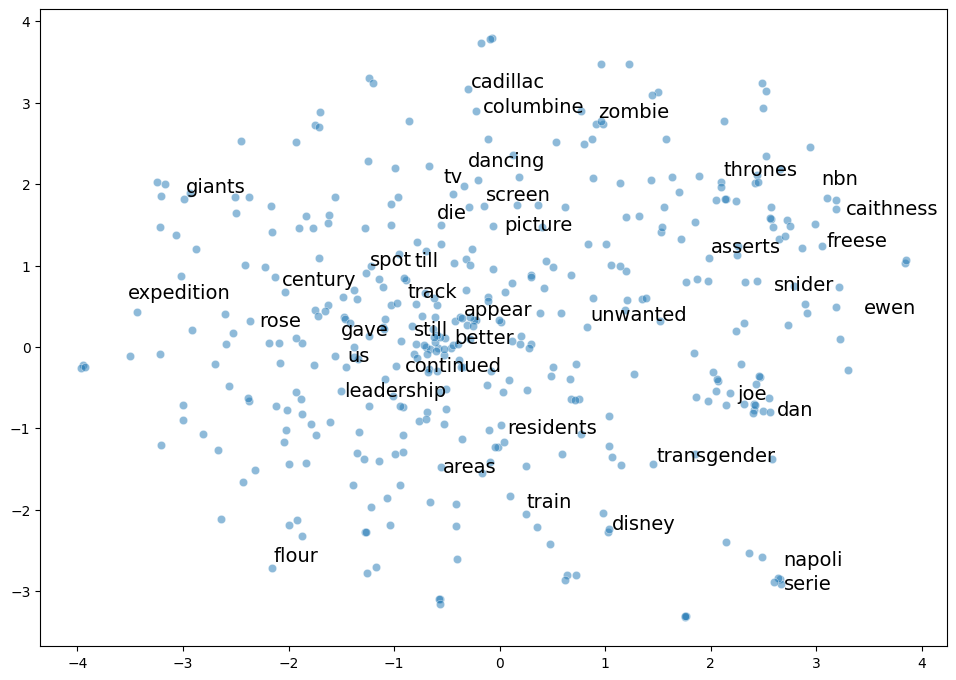

In [ ]:
#model.index_to_key
# Filter the list of vectors to include only those that GloVe has a vector for
vector_list = [glove_model[word] for word in words if word in glove_model.key_to_index]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in glove_model.key_to_index]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a DataFrame
word_vec_dict = dict(word_vec_zip)
df_vec = pd.DataFrame.from_dict(word_vec_dict, orient='index')
df_vec.head(3)

# ## Dimensionality Reduction with t-SNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df_vec[:400])

fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1], alpha=0.5)

texts = []
# Select words to plot
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df_vec.index[word], fontsize=14))

# Plot text using adjust_text to prevent overlap
adjust_text(texts, force_text=(0.4, 0.4), expand_points=(2, 1), expand_text=(1, 2))

plt.show()


In [ ]:

# ## Averaging Word Embeddings
#
def document_vector(glove_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in glove_model.key_to_index]
    return np.mean(glove_model[doc], axis=0)


# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc


# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(glove_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in glove_model.key_to_index for word in doc)


# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)

    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]

    corpus = [doc for doc in corpus if condition_on_doc(doc)]

    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts)



0 docs removed
0 docs removed


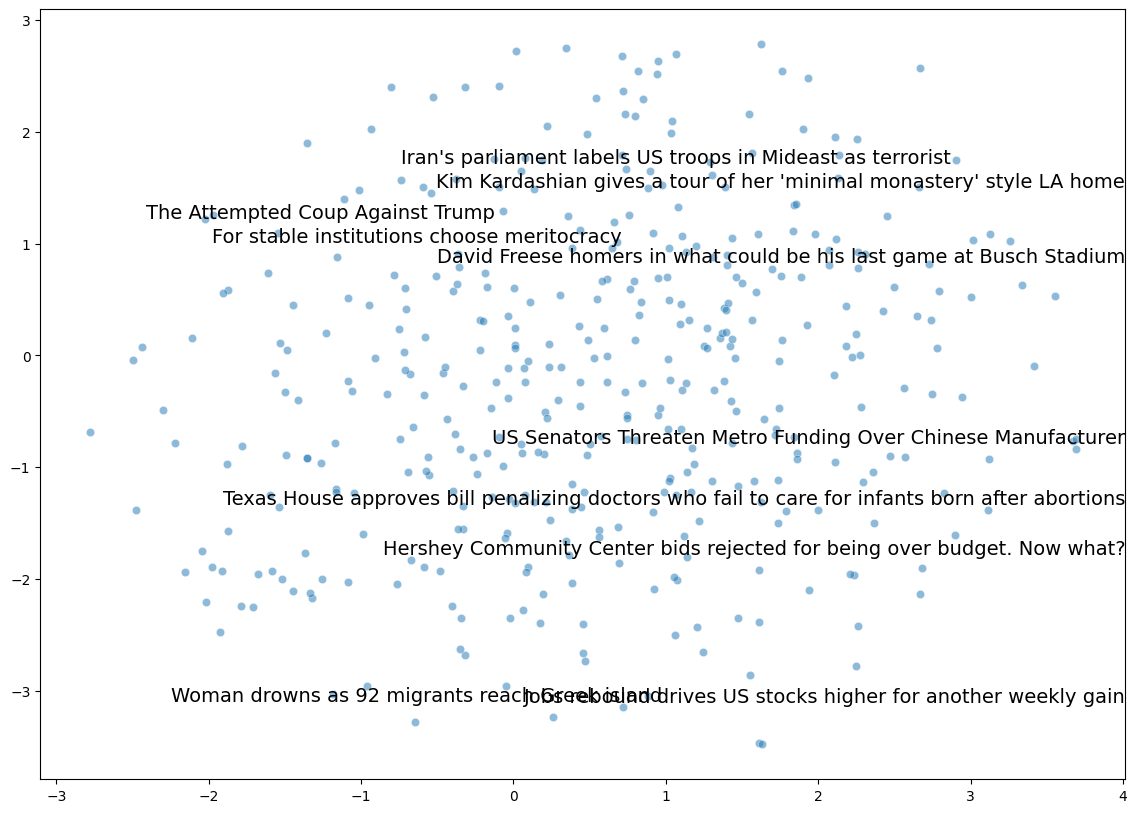

In [ ]:
# Preprocess the corpus
corpus = [preprocess(title) for title in titles_list]

# Remove docs that don't include any words in W2V's vocab
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(glove_model, doc))

# Filter out any empty docs
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
x = []
for doc in corpus: # append the vector for each document
  x.append(document_vector(glove_model, doc))

X = np.array(x) # list to array


# Initialize t-SNE
tsne = TSNE(n_components=2, init='random', random_state=10, perplexity=100)

# Again use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(X[:400])

fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1], alpha=0.5)

texts = []
titles_to_plot = list(np.arange(0, 400, 40))  # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize=14))

# Plot text using adjust_text
adjust_text(texts, force_points=0.4, force_text=(0.4, 0.4), expand_points=(2, 1), expand_text=(1, 2))

plt.show()



In [ ]:
glove_model['politics'][:20]

array([ 0.38209 , -0.1536  ,  0.44273 ,  0.015187,  0.56423 , -0.37362 ,
       -0.13583 , -0.37139 ,  0.29488 , -1.8328  , -0.1551  ,  0.16571 ,
        0.32464 ,  0.20698 ,  0.21956 , -0.1903  ,  0.15654 ,  0.28809 ,
        0.52535 ,  0.43149 ], dtype=float32)

In [ ]:

# ## Clustering topics
# topics = [
#     "Politics",
#     "Business",
#     "Technology",
#     "Health",
#     "Entertainment",
#     "Science",
#     "Environment",
#     "Sports",
#     "Education",
#     "Finance",
#     "Travel",
#     "Food",
#     "Fashion",
#     "Culture",
#     "Opinion",
#     "Weather",
#     "Crime",
#     "Art",
#     "Music",
#     "History"
# ]


# topics = [
#     "Politics",
#     "Technology",
#     "Health",
#     "Finance",
#     "Entertainment",
#     "Sports"
# ]




topics = [
    "politics",
    "business",
    "technology",
    "entertainment",
    "sports",
    "health",
    "science",
    "education",
    "environment",
    "travel",
    "fashion",
    "food",
    "finance",
    "weather",
    "crime",
    "culture",
    "art",
    "music",
    "literature",
    "history"
]

topic_embeddings = []
for topic in topics:
    # Assuming each topic is represented by a single word
    if topic in glove_model.key_to_index:
        embedding = glove_model[topic]
        topic_embeddings.append(embedding)
    else:
        # Handle out-of-vocabulary topics
        print(f"Topic '{topic}' not found in vocabulary.")

# Convert to numpy array
topic_embeddings_np = np.array(topic_embeddings)



In [ ]:
#glove_model.index_to_key

In [ ]:
topic_embeddings_np.shape
#
#X.shape
# titles_list[0]
# pd.DataFrame(X).head(3)

# Assuming you have Word2Vec embeddings for headlines stored in a DataFrame called 'embeddings_df'
# And you have Word2Vec embeddings for topics stored in a DataFrame called 'topic_embeddings_df'


# Calculate cosine similarity between each headline and each topic
# Result will be a matrix where rows represent headlines and columns represent topics
similarities = cosine_similarity(X, topic_embeddings_np)

# Find the index of the most similar topic for each headline
most_similar_topics_indices = np.argmax(similarities, axis=1)

most_similar_topics_indices

# Map indices to topic names
most_similar_topics_basis_glove = [topics[index] for index in most_similar_topics_indices]

final_df = pd.DataFrame(X)
# Add the most similar topics to the original DataFrame
final_df['most_similar_topic_glove'] = most_similar_topics_basis_glove

final_df.sample(3)
final_df['headline'] = titles_list




,headline,most_similar_topic_glove
18712,Google Patent Hints at New Google Augmented Re...,fashion
5570,Man Utd legend Sir Alex Ferguson reveals his p...,food
16711,11-Year-Old Shoves 70 Magnetic Beads Up His Pe...,environment
19586,Quash bill that would keep university presiden...,finance
22140,Deciphering the Mystery of Joy Division,literature
4769,BYU names Mark Pope its new head basketball coach,history
5969,"Supplementary Polls Peaceful in 4 Rivers LGAs,...",crime
20801,Who Is Killing Whom in the Middle East? Blamin...,art
7908,Monash University Selects Tealium To Automate ...,finance
9679,10 Rock Bands That Need A Netflix Biopic Like ...,history


No charts were generated by quickchart


In [ ]:
final_df[['headline','most_similar_topic_glove']].sample(20)


,headline,most_similar_topic_glove
10490,WikiLeaks says Assange being spied on in Ecuad...,fashion
22590,Meet the nonprofit that’s already fighting for...,environment
13232,"Ray Ratto: Sharks rediscover themselves, but i...",fashion
5957,Zimbabwe: 3 Zim Students Win Top Hackathon Award,finance
20399,The Lumineers Preview Upcoming Album With New ...,literature
16181,You're all rock stars: Inspirational young peo...,art
21068,Justin Bieber hints at collaboration with Aria...,food
19314,Gov. Jared Polis ushers in new era of drilling...,history
21367,"Mueller report, Game of Thrones, Sally Rooney,...",food
22536,Parenting Like an Economist Is a Lot Less Stre...,crime
